# Researching a Pairs Trading Strategy
By Delaney Granizo-Mackenzie

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

Notebook released under the Creative Commons Attribution 4.0 License.

---
Pairs trading is a nice example of a strategy based on mathematical analysis. The principle is as follows. Let's say you have a pair of securities X and Y that have some underlying economic link. An example might be two companies that manufacture the same product, or two companies in one supply chain. We'll start by constructing an artificial example.

## We start by generating two fake securities.
We model X's daily returns by drawing from a normal distribution. Then we perform a cumulative sum to get the value of X on each day.

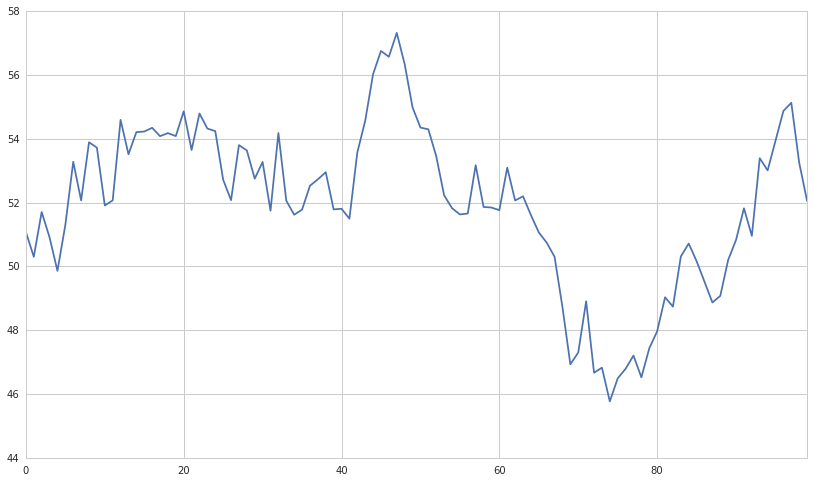

In [15]:
import numpy as np
import pandas as pd
X_returns = np.random.normal(0, 1, 100) # Generate the daily returns
# sum them and shift all the prices up into a reasonable range
X = pd.Series(np.cumsum(X_returns), name='X') + 50
X.plot()

Now we generate Y. Remember that Y is supposed to have a deep economic link to X, so the price of Y should vary pretty similarly. We model this by taking X, shifting it up and adding some random noise drawn from a normal distribution.

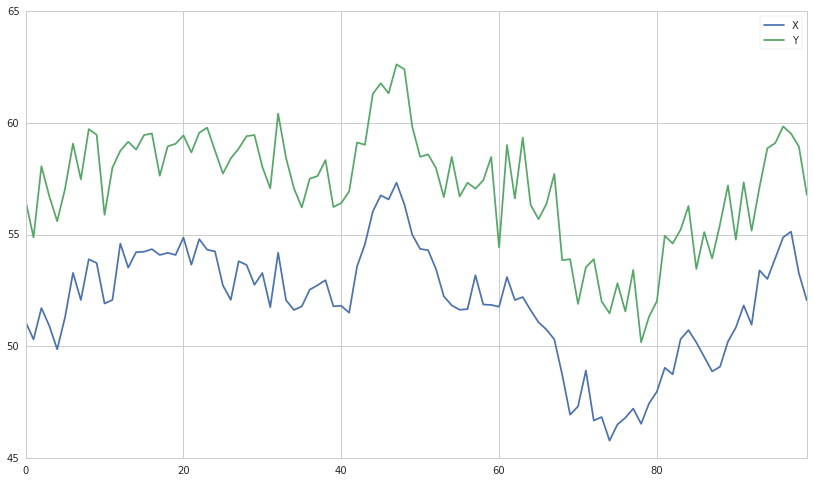

In [16]:
some_noise = np.random.normal(0, 1, 100)
Y = X + 5 + some_noise
Y.name = 'Y'
pd.concat([X, Y], axis=1).plot()

## Def: Cointegration
We've constructed an example of two cointegrated series. Cointegration is a stronger form of correlation in which not only do two signals move in the same direction, but the distance between them stays on average the same. Specifically, this is known as sharing a stochastic drift.

## Def: Hedged Position
Because you'd like to protect yourself from bad markets, often times short sales will be used to hedge long investments. Because a short sale makes money if the security sold loses value, and a long purchase will make money if a security gains value, one can long parts of the market and short others. That way if the entire market falls off a cliff, we'll still make money on the shorted securities and hopefully break even. In the case of two securities we'll call it a hedged position when we are long on one security and short on the other.

##The Trick: Where it all comes together
Because the securities drift towards and apart from each other, there will be times when the distance is high and times when the distance is low. The trick of pairs trading comes from maintaining a hedged position across X and Y. If both securities go down, we neither make nor lose money, and likewise if both go up. We make money on the difference of the two reverting to the mean. In order to do this we'll watch for when X and Y are far apart, then short Y and long X. Similarly we'll watch for when they're close together, and long Y and short X.

##Finding real securities that behave like this
The best way to do this is to start with securities you suspect may be cointegrated and perform a statistical test. If you just run statistical tests over all pairs, you'll fall prey to multiple comparison bias.

In [4]:
import statsmodels
from statsmodels.tsa.stattools import coint

As a sanity check let's run a cointegration test on the pair of fake securities X and Y.

In [17]:
score, pvalue, _ = coint(X, Y)
print pvalue
print pvalue < 0.05

1.72745705361e-16
True


Here's a method I wrote to look through a list of securities and test for cointegration between all pairs. It returns a cointegration test score matrix, a p-value matrix, and any pairs for which the p-value was less than 0.05.

In [18]:
def find_cointegrated_pairs(securities_panel):
    n = len(securities_panel.minor_axis)
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = securities_panel.keys
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = securities_panel.minor_xs(securities_panel.minor_axis[i])
            S2 = securities_panel.minor_xs(securities_panel.minor_axis[j])
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((securities_panel.minor_axis[i], securities_panel.minor_axis[j]))
    return score_matrix, pvalue_matrix, pairs

## Looking for Cointegrated Pairs of Alternative Energy Securities
I'm looking through a set of solar company stocks to see if any of them are cointegrated. We'll start by defining the list of securities we want to look through. Then we'll get the pricing data for each security for the year of 2014.

In [19]:
symbol_list = ['ABGB', 'ASTI', 'CSUN', 'DQ', 'FSLR', 'HK', 'AAPL', 'MSFT']
securities_panel = get_pricing(symbol_list, fields=['price'], start_date='2014-01-01', end_date='2015-01-01')
securities_panel.minor_axis = map(lambda x: x.symbol, securities_panel.minor_axis)

[2015-04-07 19:00:22.798798] INFO: requests.packages.urllib3.connectionpool: Starting new HTTP connection (1): localhost
[2015-04-07 19:00:23.317863] DEBUG: requests.packages.urllib3.connectionpool: "POST /api/pricing HTTP/1.1" 200 26560


Now we'll run our method on the list and see if any pairs are cointegrated.

[(u'ABGB', u'FSLR'), (u'CSUN', u'AAPL')]


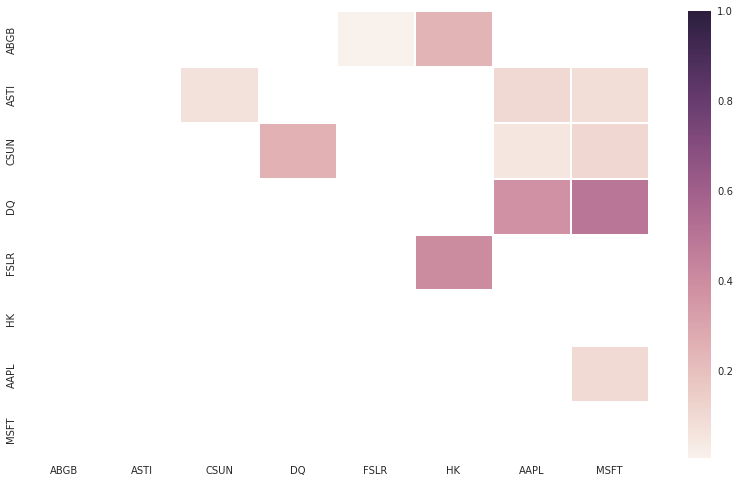

In [20]:
# series_list = load_prices(symbol_list)
scores, pvalues, pairs = find_cointegrated_pairs(securities_panel)
import seaborn
seaborn.heatmap(pvalues, xticklabels=symbol_list, yticklabels=symbol_list, mask = (pvalues >= 0.5))
print pairs

Looks like 'ABGB' and 'FSLR' are cointegrated. Let's take a look at the prices to make sure there's nothing weird going on.

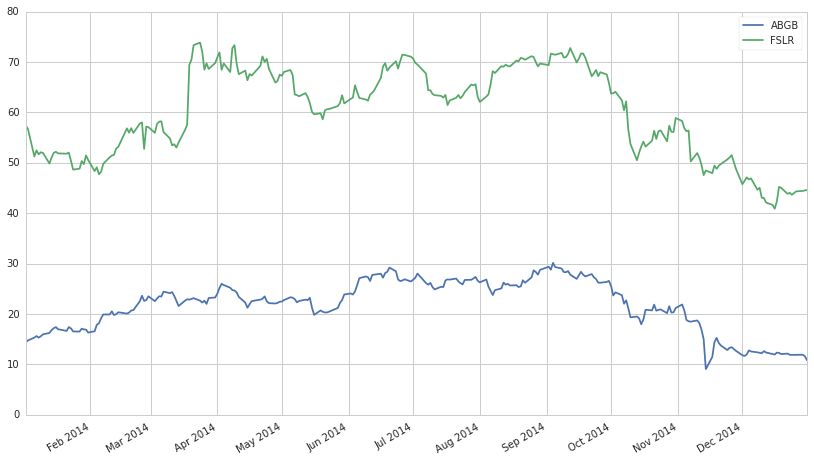

In [21]:
S = securities_panel.loc['price', :, ['ABGB', 'FSLR']]
S.plot()

## Def: Moving Average
A moving average is just an average over the last $n$ datapoints for each given time. It will be undefined for the first $n$ datapoints in our series.

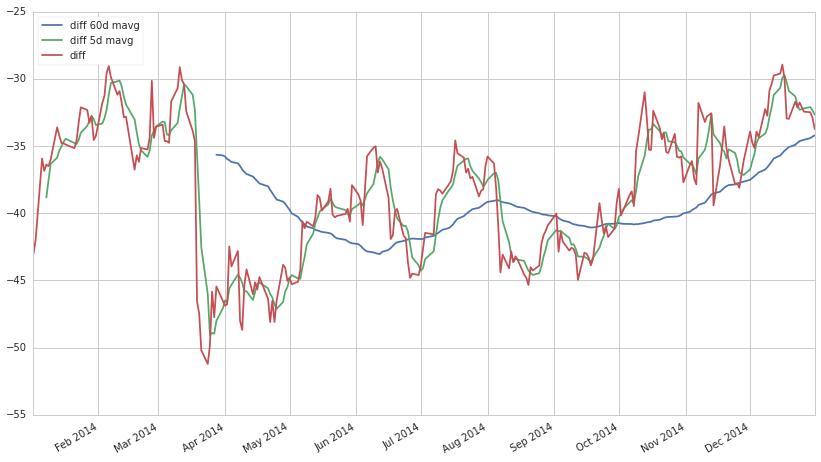

In [22]:
# Get the difference
difference = securities_panel.loc['price', :, 'ABGB'] - securities_panel.loc['price', :, 'FSLR']
difference.name = 'diff'
# Get the 5 day moving average of the difference
diff_mavg5 = pd.rolling_mean(difference, window=5)
diff_mavg5.name = 'diff 5d mavg'
# Get the 60 day moving average
diff_mavg60 = pd.rolling_mean(difference, window=60)
diff_mavg60.name = 'diff 60d mavg'

pd.concat([diff_mavg60, diff_mavg5, difference], axis=1).plot()

We can use the moving averages to compute the z-score of the difference at each given time. This will tell us how extreme the difference is and whether it's a good idea to enter a position at this time. Let's take a look at the z-score now.

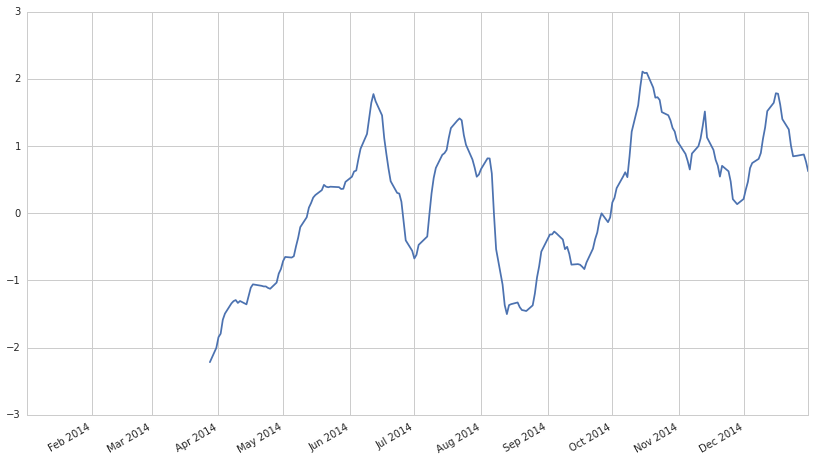

In [23]:
# Take a rolling 60 day standard deviation
std_60 = pd.rolling_std(difference, window=60)
std_60.name = 'std 60d'

# Compute the z score at each time
zscore = (diff_mavg5 - diff_mavg60)/std_60
zscore.name = 'z-score'
zscore.plot()

The z-score doesn't mean much out of context, let's plot it next to the prices to get an idea of what it looks like. We'll take the negative of the z-score because the differences were all negative and that's kinda confusing.

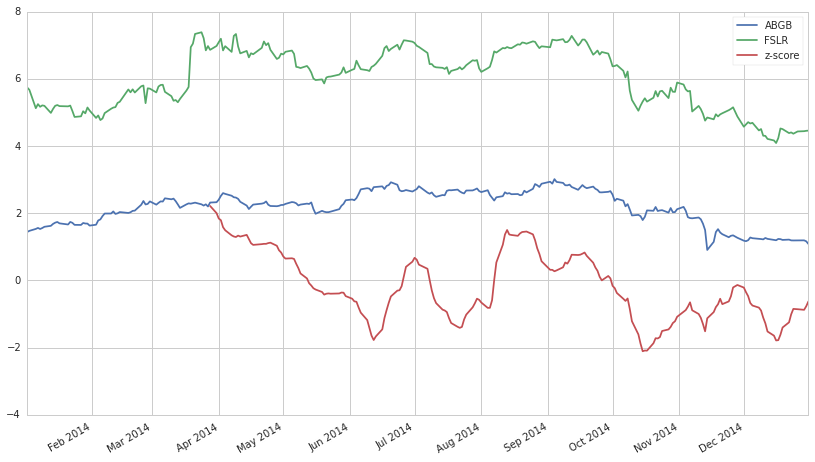

In [13]:
# Plot the prices scaled down along with the negative z-score
pd.concat([S/10, -zscore], axis=1).plot()